In [1]:
import warnings
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Activation
from keras.optimizers import Adamax, RMSprop, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LeakyReLU, ELU, PReLU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# File Path
diabetes_data_to_load = Path("../Outputs/DIABETES_sdoh_access.csv")

# Read shcool metrics into Pandas DataFrames
diabetes_df = pd.read_csv(diabetes_data_to_load)

diabetes_df.head()

,county_index,target_diabetes,AGE65,BROAD,CROWD,HCOST,NOHSDP,POV150,REMNRTY,SNGPNT,UNEMP,No_Vehicle_10_Miles,No_Vehicle_1_Mile,No_Vehicle_Half_Mile
0,1001,10.7,15.1,14.5,1.5,21.5,10.4,21.7,26.9,7.1,2.8,0.406809,1.528284,1.914937
1,1011,18.7,16.2,40.6,0.8,23.9,22.4,46.0,79.6,14.5,3.0,0.733003,3.060290,3.967381
2,1021,11.5,16.4,21.7,2.9,16.1,18.2,26.5,20.7,4.5,6.4,0.025205,1.416035,1.718489
3,1029,11.0,19.2,27.2,2.1,18.1,16.9,27.3,7.6,4.5,4.5,0.073470,1.302431,1.436014
4,1049,12.5,16.9,20.1,3.3,20.9,21.8,35.4,20.4,5.8,4.3,0.000000,1.492076,1.816929


In [3]:
# Divide the percentage values by 100 to prepare for Neural Network
columns_to_scale = diabetes_df.dtypes[diabetes_df.dtypes == "float64"].index.tolist()
diabetes_df[columns_to_scale] = diabetes_df[columns_to_scale] / 100
diabetes_df.head()

,county_index,target_diabetes,AGE65,BROAD,CROWD,HCOST,NOHSDP,POV150,REMNRTY,SNGPNT,UNEMP,No_Vehicle_10_Miles,No_Vehicle_1_Mile,No_Vehicle_Half_Mile
0,1001,0.107,0.151,0.145,0.015,0.215,0.104,0.217,0.269,0.071,0.028,0.004068,0.015283,0.019149
1,1011,0.187,0.162,0.406,0.008,0.239,0.224,0.460,0.796,0.145,0.030,0.007330,0.030603,0.039674
2,1021,0.115,0.164,0.217,0.029,0.161,0.182,0.265,0.207,0.045,0.064,0.000252,0.014160,0.017185
3,1029,0.110,0.192,0.272,0.021,0.181,0.169,0.273,0.076,0.045,0.045,0.000735,0.013024,0.014360
4,1049,0.125,0.169,0.201,0.033,0.209,0.218,0.354,0.204,0.058,0.043,0.000000,0.014921,0.018169


In [4]:
# Split data into our features and target arrays
y = diabetes_df['target_diabetes'].values
X = diabetes_df.drop(columns = ['target_diabetes', 'county_index']).values

# Split the arrays into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

# Data was prescaled manually so set values to work with the train_model function
X_train_scaled = X_train
X_test_scaled = X_test

# Set the values for input shape and hidden nodes for each layer
input_shape = len(X_train[0])
hidden_nodes_layer1 =  128
hidden_nodes_layer2 = 64
hidden_nodes_layer3 = 32

In [5]:
def train_model(X_train_scaled, y_train, X_test_scaled, y_test, activation_func='relu'):
    """
    Train a neural network with specified activation function and multiple optimizers.

    Args:
    - X_train_scaled: Scaled training data
    - y_train: Labels for training data
    - X_test_scaled: Scaled test data
    - y_test: Labels for test data
    - activation_func: Activation function to use (e.g., 'relu', 'leaky_relu', 'elu', 'prelu', 'swish')

    Returns:
    - mae_list2: List of mean absolute error for each optimizer
    - loss_list2: List of losses (MSE) for each optimizer
    """
    
    # Custom activation handling
    def get_activation(activation):
        if activation == 'leaky_relu':
            return LeakyReLU(alpha=0.1)  # Custom activation layer
        elif activation == 'elu':
            return ELU(alpha=1.0)  # Custom activation layer
        elif activation == 'prelu':
            return PReLU()  # Custom activation layer
        elif activation == 'swish':  # Or silu
            return Activation(tf.keras.activations.swish)  # Wrap as Activation layer
        else:
            return activation  # For standard activations like 'relu', 'sigmoid', etc.
    
    # Define the model
    nn = tf.keras.models.Sequential()

    # Add the input layer
    nn.add(tf.keras.layers.Input(shape=(input_shape,)))
    
    # First hidden layer
    if isinstance(get_activation(activation_func), str):  # If it's a standard activation
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation=get_activation(activation_func)))  # Use activation as string
    else:  # If it's a custom activation layer
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1))
        nn.add(get_activation(activation_func))  # Add custom activation layer
    
    # Dropout and subsequent layers
    nn.add(Dropout(0.3))
    if isinstance(get_activation(activation_func), str):
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation=get_activation(activation_func)))
    else:
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2))
        nn.add(get_activation(activation_func))
    
    nn.add(Dropout(0.3))
    if isinstance(get_activation(activation_func), str):
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation=get_activation(activation_func)))
    else:
        nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3))
        nn.add(get_activation(activation_func))
    
    # Output layer (for continuous data)
    nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # Experiment with different optimizers
    optimizers = {
        'Adamax': Adamax(learning_rate=0.002),
        'RMSprop': RMSprop(learning_rate=0.001),
        'SGD': SGD(learning_rate=0.01, momentum=0.9)
    }

    mae_list2 = []
    loss_list2 = []

    # Iterate through each optimizer
    for name, optimizer in optimizers.items():
        print(f"\nTraining with {name} optimizer and {activation_func} activation function...")
        nn.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["MAE"])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        # Train the model
        nn.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test),
               callbacks=[early_stopping, reduce_lr], verbose=1)

        # Evaluate the model
        loss, mae = nn.evaluate(X_test_scaled, y_test, verbose=0)
        print(f"{name} Optimizer - Loss (MSE): {loss:.6f}, Mean Absolute Error: {mae:.6f}")
        mae_list2.append(mae)
        loss_list2.append(loss)
    
    return mae_list2, loss_list2

In [6]:
all_mae_values = []
all_loss_values = []
all_labels = []
all_activation_functions = []
all_optimizers = []

activation_functions = ['relu', 'leaky_relu', 'elu', 'prelu', 'swish']
optimizers = ['Adamax', 'RMSprop', 'SGD']

for activation in activation_functions:
    print(f"\nRunning for activation function: {activation}")
    mae_list, loss_list = train_model(X_train_scaled, y_train, X_test_scaled, y_test, activation_func=activation)
    
    # Append the Mean Absolute Error, loss values and labels for this activation function
    all_mae_values.extend(mae_list)
    all_loss_values.extend(loss_list)
    
    # Create labels combining activation function and optimizer
    for optimizer in optimizers:
        all_labels.append(f"{activation}, {optimizer}")
        all_activation_functions.append(activation)
        all_optimizers.append(optimizer)


Running for activation function: relu

Training with Adamax optimizer and relu activation function...
Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - MAE: 0.0298 - loss: 0.0015 - val_MAE: 0.0250 - val_loss: 8.0299e-04 - learning_rate: 0.0020
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0143 - loss: 3.3779e-04 - val_MAE: 0.0219 - val_loss: 6.5268e-04 - learning_rate: 0.0020
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0118 - loss: 2.3219e-04 - val_MAE: 0.0175 - val_loss: 4.6834e-04 - learning_rate: 0.0020
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0112 - loss: 2.2645e-04 - val_MAE: 0.0182 - val_loss: 5.0658e-04 - learning_rate: 0.0020
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0107 - loss: 2.0060e-04 - val_MAE: 0.0185 - val_loss: 5.2651e-04 - learning_rate: 0.0020
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0104 - loss: 1.8126e-04 - val_MAE: 0.0150 - val_loss: 3.7078e-04 - learning_rate: 0.0020
Epoch 7

C:\Users\ecros\anaconda3\envs\dev\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - MAE: 0.0361 - loss: 0.0029 - val_MAE: 0.0142 - val_loss: 3.0878e-04 - learning_rate: 0.0020
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0163 - loss: 4.5449e-04 - val_MAE: 0.0158 - val_loss: 3.6406e-04 - learning_rate: 0.0020
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0135 - loss: 3.0654e-04 - val_MAE: 0.0153 - val_loss: 3.5565e-04 - learning_rate: 0.0020
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0118 - loss: 2.4763e-04 - val_MAE: 0.0137 - val_loss: 2.8988e-04 - learning_rate: 0.0020
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0114 - loss: 2.2944e-04 - val_MAE: 0.0132 - val_loss: 2.6072e-04 - learning_rate: 0.0020
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0107 - loss: 1.8990e-04 - val_MAE: 0.0112 - val_loss: 2.0530e-04 - learning_rate: 0.0020
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.0104 - loss: 1.8219e-04 - val_MAE: 0.0119 - val_loss: 2.1843e-

In [7]:
print(all_mae_values)
print(all_loss_values)
print(all_labels)

[0.011207601986825466, 0.009374559856951237, 0.010235217399895191, 0.008988910354673862, 0.006932845804840326, 0.007163891103118658, 0.0060432846657931805, 0.00583536084741354, 0.0058356039226055145, 0.010863609611988068, 0.007580493576824665, 0.008018002845346928, 0.0059814476408064365, 0.005903446581214666, 0.005903397221118212]
[0.0002262256748508662, 0.00016063638031482697, 0.00018793964409269392, 0.00012902195157948881, 8.238020382123068e-05, 8.815292676445097e-05, 6.438737182179466e-05, 6.004888564348221e-05, 6.015436156303622e-05, 0.00019411626271903515, 0.00010305707110092044, 0.00011392113810870796, 6.065687193768099e-05, 5.92362521274481e-05, 5.916215741308406e-05]
['relu, Adamax', 'relu, RMSprop', 'relu, SGD', 'leaky_relu, Adamax', 'leaky_relu, RMSprop', 'leaky_relu, SGD', 'elu, Adamax', 'elu, RMSprop', 'elu, SGD', 'prelu, Adamax', 'prelu, RMSprop', 'prelu, SGD', 'swish, Adamax', 'swish, RMSprop', 'swish, SGD']


In [8]:
# Create a DataFrame
diabetes_models_df = pd.DataFrame({
    'Model': all_labels, 
    'Activation_Function': all_activation_functions, 
    'Optimizer': all_optimizers, 
    'MAE': all_mae_values, 
    'Loss': all_loss_values
})

diabetes_models_df

,Model,Activation_Function,Optimizer,MAE,Loss
0,"relu, Adamax",relu,Adamax,0.011208,0.000226
1,"relu, RMSprop",relu,RMSprop,0.009375,0.000161
2,"relu, SGD",relu,SGD,0.010235,0.000188
3,"leaky_relu, Adamax",leaky_relu,Adamax,0.008989,0.000129
4,"leaky_relu, RMSprop",leaky_relu,RMSprop,0.006933,0.000082
5,"leaky_relu, SGD",leaky_relu,SGD,0.007164,0.000088
6,"elu, Adamax",elu,Adamax,0.006043,0.000064
7,"elu, RMSprop",elu,RMSprop,0.005835,0.000060
8,"elu, SGD",elu,SGD,0.005836,0.000060
9,"prelu, Adamax",prelu,Adamax,0.010864,0.000194


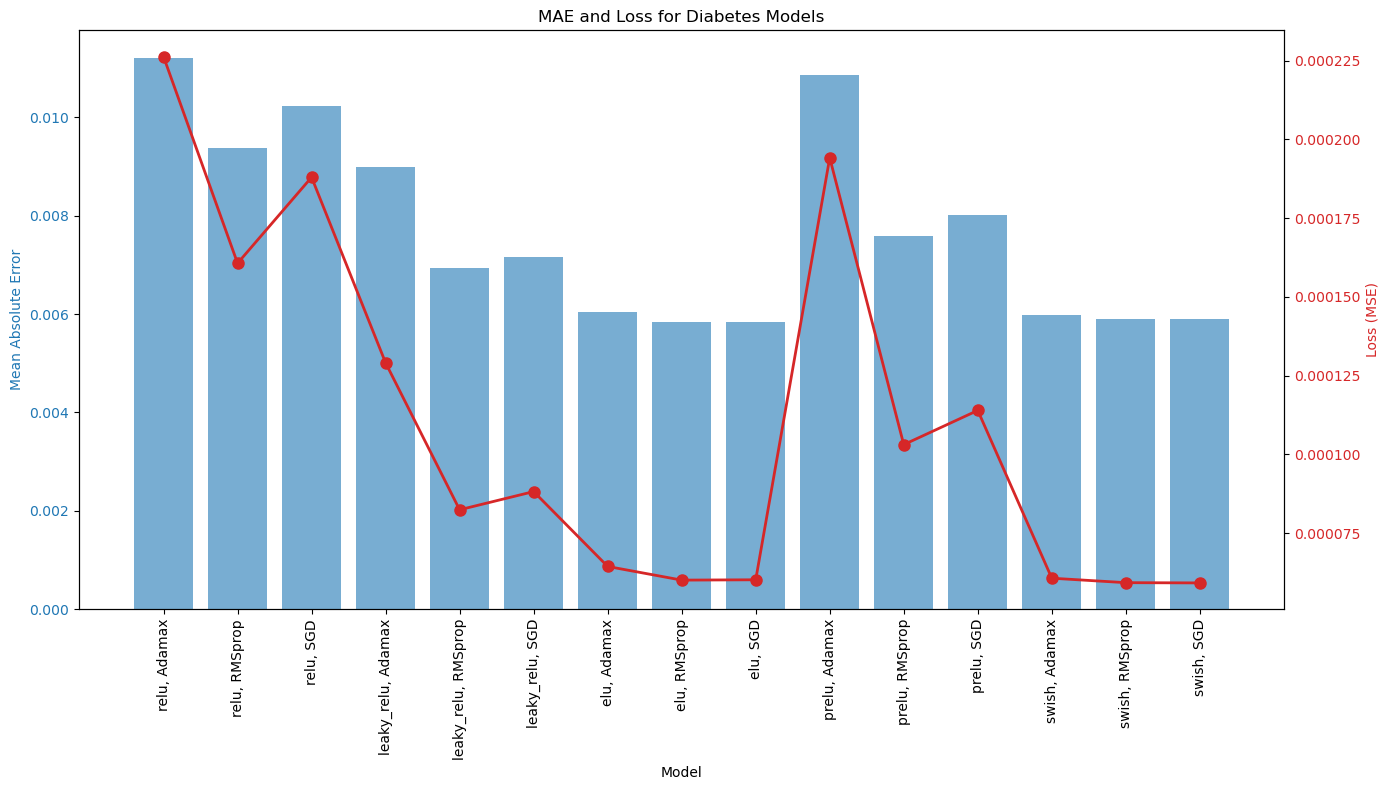

In [9]:
# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for Accuracy
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Absolute Error', color=color)
ax1.bar(diabetes_models_df['Model'], diabetes_models_df['MAE'], color=color, alpha=0.6, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(diabetes_models_df['Model'])))
ax1.set_xticklabels(diabetes_models_df['Model'], rotation=90)

# Create a second y-axis for Loss
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Loss (MSE)', color=color)
ax2.plot(diabetes_models_df['Model'], diabetes_models_df['Loss'], color=color, marker='o', linestyle='-', linewidth=2, markersize=8, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('MAE and Loss for Diabetes Models')
fig.tight_layout()
plt.show()

In [10]:
# Rank the models based on MAE (lower is better)
diabetes_models_df['MAE_Rank'] = diabetes_models_df['MAE'].rank()

# Rank the models based on Loss (lower is better)
diabetes_models_df['Loss_Rank'] = diabetes_models_df['Loss'].rank()

# Calculate the average rank
diabetes_models_df['Average_Rank'] = (diabetes_models_df['MAE_Rank'] + diabetes_models_df['Loss_Rank']) / 2

# Find the top two ranked models
best_model_avg_rank = diabetes_models_df.sort_values('Average_Rank').iloc[0]
print(best_model_avg_rank)

Model                  elu, RMSprop
Activation_Function             elu
Optimizer                   RMSprop
MAE                        0.005835
Loss                        0.00006
MAE_Rank                        1.0
Loss_Rank                       3.0
Average_Rank                    2.0
Name: 7, dtype: object
